# Skew

This is a very important topic that explains a lot of the rules of thumbs used in this field regarding hypothesis testing.

For instance, in [Kohavi et al., 2014](https://www.exp-platform.com/Documents/2014%20experimentersRulesOfThumb.pdf), their rule of thumb for the minimum numer of independent and identically distributed observations needed for the mean to have a normal distribution is $355\times s^2$ for each variant, where $s$ is the skewness coefficient of the distribution of the variable $X$, and further explaining that this rule of thumb be used when $|\text{skewness}|>1$.

What does any of this mean? That's the point of this notebook.

# Introduction

Kohavi et al.,'s recommendation for performing hypothesis tests are to use $t$-tests (or $z$-tests for proportion metrics) as default unless the data is too skewed (even with strategies like capping), which we then may move to bootstrap / nonparametric tests.

The reason we use tests that assume normality is that with sufficient sample size, the test is promised, generally speaking, unbiasedness via one of the most important theorems in statistics, the central limit theorem, which state that

$$P(Z_n\leq t)\rightarrow P(Z\leq t)\text{ as }n\rightarrow\infty,\text{ for all }t\in (-\infty,\infty)$$

where $Z$ is a standard normal random variable and $Z_n=\sqrt{n}(\bar X-\mu)/\sigma$ and $\bar X$ is the sample mean of our experimentation data.

While this fact is well-known, what's less discussed is the fact that based on a variety of factors, the number of samples it takes to converge to normality can vary. More samples mean better convergence, but depending on how skewed your data is, this will impact how many samples you will need.

# Show a distribution converge to normality

"How many samples do we need to converge to normality" means how many samples do we need to average for it to be normally distributed.

For example, let's say we can sample as many values as we want from some Exponential Distribution with $\lambda=1$. If we defined a sample mean as averaging 1 sample, then of-course the distribution of this sample mean definition would just be the Exponential Distribution with $\lambda=1$. But if you defined a sample mean as the average of 30 samples, then the distribution of that becomes more normally distributed.

Let's visualize that below:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def visualize_sample_means(sample_size):
  """
  """
  import numpy as np
  import matplotlib.pyplot as plt

  # how many rows
  data_size = 10000

  # samples the appropriate # from exponential and also gets the sample means
  samples = np.random.exponential(scale=1, size=data_size*sample_size).reshape(data_size, sample_size)
  sample_means = np.mean(samples, axis=1)

  # Calculate the mean and standard deviation of the sample means
  mean = np.mean(sample_means)
  std_dev = np.std(sample_means)

  # plot the sample means
  plt.hist(sample_means, bins=30, density=True, alpha=0.6, color='g')

  # Get the current limits for x-axis after plotting the histogram
  xmin, xmax = plt.xlim()

  # Generate x values for the normal distribution plot
  x = np.linspace(xmin-1, xmax, 100)

  # Generate the normal distribution values
  p = stats.norm.pdf(x, mean, std_dev)

  # Plot the normal distribution
  plt.plot(x, p, 'k', linewidth=2)

  # Add a title with mean and standard deviation
  plt.title(f'sample size of {sample_size}')

def sample_size_compare(sample_sizes = [1, 5, 10, 15, 20, 30]):
  """
  """
  import matplotlib.pyplot as plt
  # Create a 2x3 subplot layout
  plt.figure(figsize=(15, 10))

  for i, sample_size in enumerate(sample_sizes):
    plt.subplot(2, 3, i+1)
    visualize_sample_means(sample_size)

  plt.tight_layout()
  plt.show()


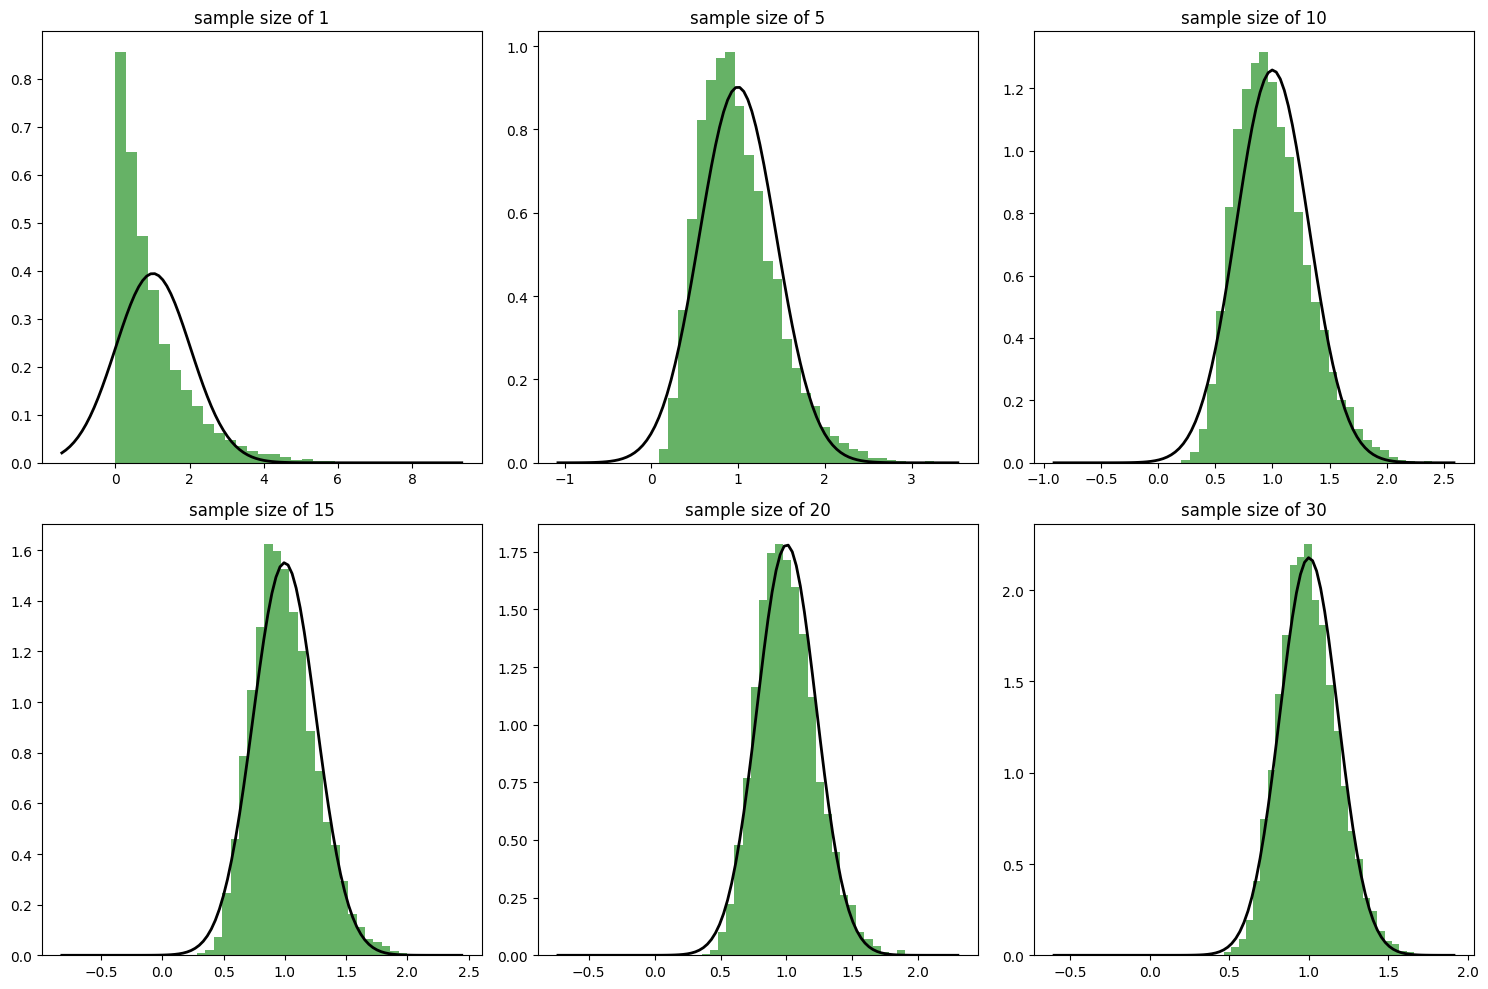

In [ ]:
sample_size_compare()

We see that by sample size of 20 (remember, this means we're averaging 20 samples), the distribution of our sample means are already remarkably close to normal. This may spark the familiar knowledge from an introductory class that you need 30 samples as a rule of thumb to achieve normality.

While sample size is something that determines how normal the distribution of your sample means become, it's actually the skew of the distribution that is even more important, it is one of the aspects of a distribution that dictates how large your sample will have to be to converge.

Let's discuss this. First off, in [Kohavi et al., 2014](https://www.exp-platform.com/Documents/2014%20experimentersRulesOfThumb.pdf), he mentions the skewness coefficient of the distribution of the variable $X$, which is defined as:

$$S=\frac{E[X-E(X)]^3}{[\text{var}(X)]^{3/2}}$$

This is actually the exact same as `scipy.stats.skew(x, bias=True)`. Let's create our own function for it and compute the skew

In [ ]:
import numpy as np

def skewness(data):
    # Calculate the mean of the data
    mean = np.mean(data)

    # Calculate the third central moment (expected value of the cubed deviation from the mean)
    third_moment = np.mean((data - mean) ** 3)

    # Calculate the variance (second central moment)
    variance = np.var(data)

    # Calculate the skewness using the formula
    skew = third_moment / (variance ** (3/2))

    return skew

In [ ]:
# Example usage:
data_size = 100000
sample_size = 1
samples = np.random.exponential(scale=1, size=data_size*sample_size).reshape(data_size, sample_size)
data = np.mean(samples, axis=1)
skew = skewness(data)
print("Skewness:", skew)

Skewness: 1.9913386098488104


By the way, this isn't surprising at all - the skew of an Exponential distribution is always 2.

# Relation to Sample Size Calculation

Kohavi then recommends that if the distribution of your data has $|\text{skewness}|>1$, then to use the rule of thumb of $355s^2$ for each variant. In our case, $355\times 2^2=1420$ samples needed per variant to achieve normality. We will discuss where this rule of thumb comes from later but let's first move on and think about how this applies to sample size calculation for 80% power and 5% alpha:

Remember van Belle's sample size formula (per variant):

$$n=\frac{16\sigma^2}{\delta^2}$$

Let's apply it here:

In [ ]:
def sample_size_formula(data, delta=0.1):
    return round((16 * np.var(data)) / ((np.mean(data)*delta) ** 2))

In [ ]:
sample_size_formula(data, delta=0.1)

1612

In other words, for a relative lift of 10%, we need 1600 samples per variant, and because this is greater than 1420, we are safe to use this, since we've already reached the recommended level of normality. If instead we were interested in a 20% lift,

In [ ]:
sample_size_formula(data, delta=0.2)

403

Then our data wouldn't be able to achieve normality. In other words, there is a cap to what kind of lifts you are able to measure based on the skewness coefficient.

Another way to quantify if a data is normal is using a QQ-norm plot, which we can use below:

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def transform_to_t_statistic(data):
  # Calculate the mean and standard deviation of each row
  mean = np.mean(data)
  std_dev = np.std(data)

  # Calculate the t statistic for each row
  t_statistic = (data - mean) / std_dev

  return t_statistic

def plot_qqnorm(sample_size=1, ax = None):
  """
  """
  data_size=10000
  samples = np.random.exponential(scale=1, size=data_size*sample_size).reshape(data_size, sample_size)
  data = np.mean(samples, axis=1)
  t_statistic = transform_to_t_statistic(data)

  if ax:
    sm.qqplot(t_statistic, line='45',ax=ax)
  else:
    sm.qqplot(t_statistic, line='45')
    plt.title(f'Q-Q plot, Sample Size = {sample_size}')

def qqnorm_compare(sample_sizes = [1, 30, 50, 100, 500, 1420]):
  """
  """
  import matplotlib.pyplot as plt
  # Create a 2x3 subplot layout
  plt.figure(figsize=(15, 10))
  fig, axes = plt.subplots(nrows=2, ncols=3)
  for s, ax in zip(sample_sizes, np.ravel(axes)):
    plot_qqnorm(s, ax=ax)
    ax.set_title(f'sample size {s}')

  plt.tight_layout()

<Figure size 1500x1000 with 0 Axes>

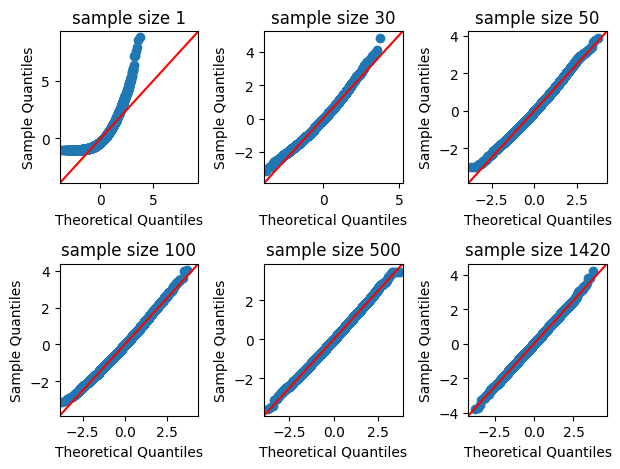

In [ ]:
qqnorm_compare()